Lets load required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import itertools
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

%matplotlib inline

import matplotlib.ticker as ticker
from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


# Introduction
A large Indian Liquor company wants to set their shop in/around Gurgaon. They wants to evaluate the place where to open their shop. As cost involve in opening and closing store is very high, company CEO wants to evaluate the model through which the executive have decided to open the shop in that area. Company only manufacture Beer Product so executive wants to know the area in which cost of Beer is high. So that they can sell the Beer with competitive price and at the same time have laverage to manipulate the price if needed without taking any profitibality hit.

# Data 

Based on definition of our problem, factors that will influence our decission are:
    - location of existing Beer bar in the neighborhood

We decided to use regularly spaced grid of locations, centered around Gurgaon, to define our neighborhoods.
Following data sources will be needed to extract/generate the required information:

    -location in every neighborhood will be obtained using Foursquare API


# Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 50 killometers centered around Berlin city center.
Let's first find the latitude & longitude of Berlin city center, using specific, well known address and FourSquare API.


In [2]:
address = 'Gurgaon, HR'

geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Gurgaon are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Gurgaon are 28.4646148, 77.0299194.


In [3]:
CLIENT_ID = 'QRVTIFWELRPDR32D24J5PIOHO0ZPOI2IV4DLEQ41BRFM14ZX'#'BH35Y2LKXSR3RZ33XW3B45KBOSF4FMAUIGQZHPFW25EZRZFE'#'0FBT41TCGZO3B2H2S5VEEIAZB4ONY13ZXOFVFA2KGWYT0DME' # your Foursquare ID
CLIENT_SECRET = 'UZUDC1TLLOEEAOT2KBPSPW02OC5ARHHI5M3FM1XZNYOKX3Z3'#'JLUIBN2C5EHEZ2GG342WWLGHELPVVJ5F4VNEIYYN1YSZITVZ'#'E0ER3ILWAS5BZKWPP4HESWBFPY4RUXEDC01VEMGXQLYCEJ1O' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QRVTIFWELRPDR32D24J5PIOHO0ZPOI2IV4DLEQ41BRFM14ZX
CLIENT_SECRET:UZUDC1TLLOEEAOT2KBPSPW02OC5ARHHI5M3FM1XZNYOKX3Z3


In [4]:
# type your answer here
search_query = 'Beer Bar'
radius = 50000
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    latitude,
    longitude,
    search_query,
    radius,
    LIMIT)

url


'https://api.foursquare.com/v2/venues/search?client_id=QRVTIFWELRPDR32D24J5PIOHO0ZPOI2IV4DLEQ41BRFM14ZX&client_secret=UZUDC1TLLOEEAOT2KBPSPW02OC5ARHHI5M3FM1XZNYOKX3Z3&v=20180605&ll=28.4646148,77.0299194&query=Beer Bar&radius=50000&limit=100'

In [5]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d29408da87921002ce170d4'},
 'response': {'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/diner_',
       'suffix': '.png'},
      'id': '4bf58dd8d48988d147941735',
      'name': 'Diner',
      'pluralName': 'Diners',
      'primary': True,
      'shortName': 'Diner'}],
    'hasPerk': False,
    'id': '5760083d498eae687d617eb3',
    'location': {'address': 'United - 21 Citymark Gurgaon Behind Punjab National Bank',
     'cc': 'IN',
     'city': 'Delhi-NCR',
     'country': 'India',
     'crossStreet': 'MahavirChowk; Gurgaon',
     'distance': 278,
     'formattedAddress': ['United - 21 Citymark Gurgaon Behind Punjab National Bank (MahavirChowk; Gurgaon)',
      'Delhi-NCR 122001',
      'Delhi',
      'India'],
     'labeledLatLngs': [{'label': 'display',
       'lat': 28.463808,
       'lng': 77.032614}],
     'lat': 28.463808,
     'lng': 77.032614,
     'postalCode': '122001',
     'state': 'Delhi'},
  

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venues.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
venues = results['response']['venues']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['id', 'name', 'categories', 'location.lat', 'location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(7)

,id,name,categories,lat,lng
0,5760083d498eae687d617eb3,Waves Lounge Bar,Diner,28.463808,77.032614
1,5d2375bfd29cbb0023707cd7,The Beer Cafe,Bar,28.461802,77.050540
2,4d52aeb63062a1cd34ff73a3,Shama Motel & Bar,Dive Bar,28.462234,77.032420
3,56035d6d498e3b8831ccc006,beer garden,Brewery,28.455168,77.052031
4,55237d32498e1210f6c94710,Illusion The Lounge Bar,Diner,28.458033,77.033857
5,52b2c399498ebc63b2841f29,Illusion Bar - Clarks Inn,Bar,28.457955,77.034596
6,52df981811d2267bd02008ca,The Beer Cafe,Indian Restaurant,28.480703,77.068383


In [8]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

50 venues were returned by Foursquare.


In [9]:
def getVenues(ids, names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for idx, name, lat, lng in zip(ids, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            idx,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius,
            limit)
        
        # make the GET request
        results = requests.get(url).json()["response"]['venue']
        #print(results.get('price')['tier'])
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(
                name, 
                lat, 
                lng, 
                results.get('rating', ''),
                results.get('price')['tier'])])
            
            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['venue', 
                  'venue Latitude', 
                  'venue Longitude', 
                  'venue rating', 
                  'venue price']
        except:
            print(results)

    
    
    return(nearby_venues)

In [10]:
# type your answer here

beerBar = getVenues(ids = nearby_venues['id'],
                    names=nearby_venues['name'],
                    latitudes=nearby_venues['lat'],
                    longitudes=nearby_venues['lng']
                      )



Waves Lounge Bar
The Beer Cafe
Shama Motel & Bar
beer garden
Illusion The Lounge Bar
Illusion Bar - Clarks Inn
The Beer Cafe
Beer Factory
Godfather Beer
{'id': '52ca73a9498eff5725faccc1', 'name': 'Godfather Beer', 'contact': {}, 'location': {'lat': 28.475474, 'lng': 77.04535, 'labeledLatLngs': [{'label': 'display', 'lat': 28.475474, 'lng': 77.04535}], 'distance': 0, 'cc': 'IN', 'country': 'India', 'formattedAddress': ['India']}, 'canonicalUrl': 'https://foursquare.com/v/godfather-beer/52ca73a9498eff5725faccc1', 'categories': [{'id': '4bf58dd8d48988d124941735', 'name': 'Office', 'pluralName': 'Offices', 'shortName': 'Office', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'venueRatingBlacklisted': True, 'beenHere': {'count': 0, 'unconfirmedCount': 0, 'marked': False, 'lastCheckinExpiredAt': 0}, 'specials': 

Wine & Beer Shop
{'id': '4d8dce30788c54817f1929fd', 'name': 'Wine & Beer Shop', 'contact': {}, 'location': {'address': 'Maharana Pratap Chowk, sec-14', 'lat': 28.473187818587427, 'lng': 77.05538667791438, 'labeledLatLngs': [{'label': 'display', 'lat': 28.473187818587427, 'lng': 77.05538667791438}], 'distance': 0, 'postalCode': '122002', 'cc': 'IN', 'city': 'Gurgaon', 'state': 'Haryāna', 'country': 'India', 'formattedAddress': ['Maharana Pratap Chowk, sec-14', 'Gurgaon 122002', 'Haryāna', 'India']}, 'canonicalUrl': 'https://foursquare.com/v/wine--beer-shop/4d8dce30788c54817f1929fd', 'categories': [{'id': '4bf58dd8d48988d186941735', 'name': 'Liquor Store', 'pluralName': 'Liquor Stores', 'shortName': 'Liquor Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_liquor_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'allowMenuUrlEdit': True, 'beenHere': {'count'

Pick Your Own Beer
The Beer Café
English Wine & Beer Shop
{'id': '5a007b8295da0c2edbc66cb7', 'name': 'English Wine & Beer Shop', 'contact': {}, 'location': {'address': 'Sector 56', 'lat': 28.428653, 'lng': 77.099955, 'labeledLatLngs': [{'label': 'display', 'lat': 28.428653, 'lng': 77.099955}], 'distance': 0, 'postalCode': '122001', 'cc': 'IN', 'city': 'Gurugram', 'state': 'Haryāna', 'country': 'India', 'formattedAddress': ['Sector 56', 'Gurugram 122001', 'Haryāna', 'India']}, 'canonicalUrl': 'https://foursquare.com/v/english-wine--beer-shop/5a007b8295da0c2edbc66cb7', 'categories': [{'id': '4bf58dd8d48988d186941735', 'name': 'Liquor Store', 'pluralName': 'Liquor Stores', 'shortName': 'Liquor Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_liquor_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'allowMenuUrlEdit': True, 'beenHere': {'count': 0, 'unconfirm

Beer Shop


In [11]:
beerBar.to_csv("beer.csv", index=False)

In [12]:
beerBar.shape

(38, 5)

In [13]:
df = pd.read_csv('beer.csv')
df.head()

,venue,venue Latitude,venue Longitude,venue rating,venue price
0,Waves Lounge Bar,28.463808,77.032614,NaN,1
1,The Beer Cafe,28.461802,77.050540,NaN,2
2,Shama Motel & Bar,28.462234,77.032420,NaN,1
3,beer garden,28.455168,77.052031,NaN,2
4,Illusion The Lounge Bar,28.458033,77.033857,NaN,1


In [14]:
df['venue price'].unique()

array([1, 2, 3])

In [15]:
def dummy_rating(df):
    if (np.isnan(df['venue rating'])):
        if(df['venue price'] == 1):
            return 5
        elif(df['venue price'] == 2):
            return 7
        elif(df['venue price'] == 3):
            return 9
    else:
        return df['venue rating']

In [16]:
df['rating'] = df.apply(dummy_rating, axis=1)

In [18]:
df.drop(['venue rating'], axis=1)

,venue,venue Latitude,venue Longitude,venue price,rating
0,Waves Lounge Bar,28.463808,77.032614,1,5.0
1,The Beer Cafe,28.461802,77.050540,2,7.0
2,Shama Motel & Bar,28.462234,77.032420,1,5.0
3,beer garden,28.455168,77.052031,2,7.0
4,Illusion The Lounge Bar,28.458033,77.033857,1,5.0
5,Illusion Bar - Clarks Inn,28.457955,77.034596,2,7.0
6,The Beer Cafe,28.480703,77.068383,2,7.0
7,Beer Factory,28.480001,77.088842,1,5.0
8,Connexions Bar Crowne Plaza Gurgaon,28.468379,77.059773,2,7.0
9,The Beer Company,28.421291,77.052967,2,7.0


In [19]:
X = df[['venue Latitude', 'venue Longitude']].values
X[0:5]

array([[ 28.463808  ,  77.032614  ],
       [ 28.461802  ,  77.05054   ],
       [ 28.46223399,  77.03241981],
       [ 28.455168  ,  77.052031  ],
       [ 28.458033  ,  77.033857  ]])

In [20]:
y = df['venue price'].values
y[0:5]

array([1, 2, 1, 2, 1])

In [21]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.44917224, -1.2359886 ],
       [-0.50184852, -0.72198356],
       [-0.49050479, -1.24155669],
       [-0.67605311, -0.67923105],
       [-0.60082004, -1.20034717]])

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (30, 2) (30,)
Test set: (8, 2) (8,)


In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [38]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([2, 2, 2, 1, 2])

In [39]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.666666666667
Test set Accuracy:  0.625


In [40]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([ 0.75 ,  0.625,  0.625,  0.625,  0.5  ,  0.625,  0.5  ,  0.625,
        0.875,  0.75 ,  0.75 ,  0.875,  0.875,  0.875,  0.875,  0.875,
        0.875,  0.875,  0.875])

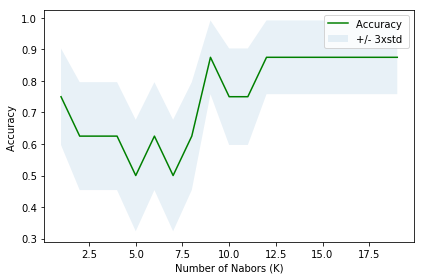

In [41]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [42]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.875 with k= 9


In [45]:
k = 9
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [46]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([2, 2, 2, 2, 2])

In [47]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.533333333333
Test set Accuracy:  0.875


In [48]:
df

,venue,venue Latitude,venue Longitude,venue rating,venue price,rating
0,Waves Lounge Bar,28.463808,77.032614,NaN,1,5.0
1,The Beer Cafe,28.461802,77.050540,NaN,2,7.0
2,Shama Motel & Bar,28.462234,77.032420,NaN,1,5.0
3,beer garden,28.455168,77.052031,NaN,2,7.0
4,Illusion The Lounge Bar,28.458033,77.033857,NaN,1,5.0
5,Illusion Bar - Clarks Inn,28.457955,77.034596,NaN,2,7.0
6,The Beer Cafe,28.480703,77.068383,NaN,2,7.0
7,Beer Factory,28.480001,77.088842,NaN,1,5.0
8,Connexions Bar Crowne Plaza Gurgaon,28.468379,77.059773,NaN,2,7.0
9,The Beer Company,28.421291,77.052967,NaN,2,7.0


# Result

After apply the model KNN to the data set obtained from FourSquare we have created a model with around 87% accuracy on the test data set. This model would have performed even better if we would have the data of rating for those restaurant but foursquare doesn't have ratings data for all the restaurant. Also we have dropped some restaurant data because price tier of those restaurant was not available in foursquare.

# Conclusion

Give then location data we will be able to identify whether opening Beer shop at that location is viable for the company or not